In [36]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from lib import *

In [2]:
human = '/home/amayer/data/proteomes/uniprot-homosapiens-up000005640.fasta'
malaria = '/home/amayer/data/proteomes/uniprot-PlasmodiumFalciparum-up000001450.fasta'
influenzaB = '/home/amayer/data/proteomes/uniprot-influenzaB-UP000127412.fasta'
cmv = '/home/amayer/data/proteomes/uniprot-cmv-UP000008991.fasta'

# Protein length distribution

20373

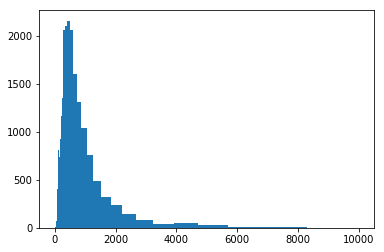

In [3]:
lens = []
nhuman = 0
for h, seq in fasta_iter(human):
    nhuman += 1
    lens.append(len(seq))
plt.hist(lens, bins=np.logspace(0, 4));
nhuman

# kmer distribution

In [4]:
counters = [count_kmers_proteome(human, k) for k in range(1, 6)]

1.137079e+07, 6.400000e+07


Text(0,0.5,'# of kmers')

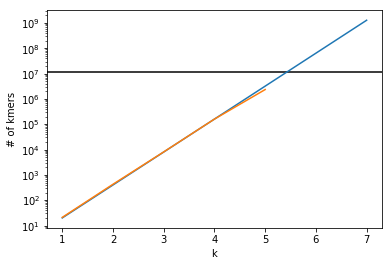

In [5]:
totalpeptides = np.sum(list(counters[0].values()))
print('%e, %e'%(totalpeptides, 20**6))
x = np.arange(1, 8)
plt.axhline(totalpeptides, color='k')
plt.plot(x, 20**x)
plt.plot(range(1, len(counters)+1), [len(c) for c in counters])
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('# of kmers')

4.321928094887363 [4.17766994 4.1694815  4.16127688 4.14678068 4.08145896] [-0.00818844 -0.00820462 -0.01449619 -0.06532172]


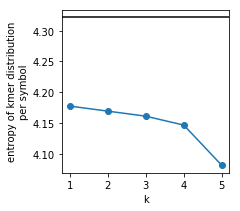

In [6]:
entropies = np.array([entropy(normalize(c), base=2)/(i+1) for i, c in enumerate(counters)])
print(np.log2(20), entropies, np.diff(entropies))
plt.figure(figsize=(3, 3))
plt.plot(np.arange(1, len(counters)+1), entropies, 'o-')
#plt.ylim(4.0, 4.35)
plt.axhline(np.log2(20), c='k')
plt.xlabel('k')
plt.ylabel('entropy of kmer distribution\nper symbol');

Text(0,0.5,'frequency')

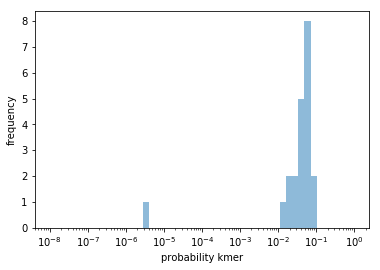

In [7]:
bins = np.logspace(-8, 0)
plt.hist(normalize(counters[0]), bins=bins, alpha=.5)
#plt.hist(normalize(counter2), bins=bins, alpha=.5)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('probability kmer')
plt.ylabel('frequency')

# Comparison of human and pathogen proteome

In [8]:
df = counter_to_df(count_kmers_proteome(human, 1), norm=True)
df2 = counter_to_df(count_kmers_proteome(cmv, 1), norm=True)
dfmerged = pd.merge(df, df2, on='seq', suffixes=['_human', '_pathogen'])
dfmerged.to_csv('data.csv')

In [9]:
entropy(dfmerged['freq_human'], dfmerged['freq_pathogen']), entropy(dfmerged['freq_pathogen'], dfmerged['freq_human'])

(0.02601775642480157, 0.02448252423812159)

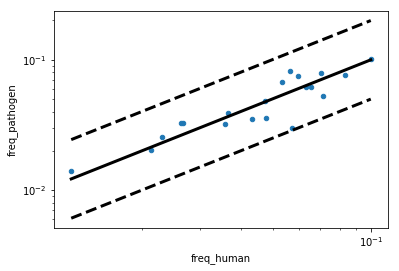

In [10]:
dfmerged.plot(x='freq_human', y='freq_pathogen', kind='scatter', logx=True, logy=True)
x = np.logspace(np.log10(np.amin(dfmerged['freq_human'])), np.log10(np.amax(dfmerged['freq_human'])))
plt.plot(x, x, 'k', lw=3)
plt.plot(x, x*2, '--k', lw=3)
plt.plot(x, x/2, '--k', lw=3)

/home/amayer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/amayer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


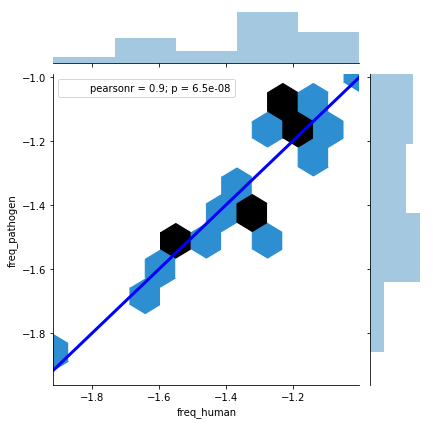

In [11]:
j = sns.jointplot(x=np.log10(dfmerged['freq_human']), y=np.log10(dfmerged['freq_pathogen']), kind="hex",
                 joint_kws=dict(gridsize=10));
x = np.logspace(np.log10(np.amin(dfmerged['freq_human'])), np.log10(np.amax(dfmerged['freq_human'])))
j.ax_joint.plot(np.log10(x), np.log10(x), 'b', lw=3)

In [12]:
dfmerged['fold'] = dfmerged['freq_pathogen']/dfmerged['freq_human']
dfmerged.sort_values('fold', ascending=False)

,seq,freq_human,freq_pathogen,fold
9,R,0.056427,0.081748,1.448744
1,T,0.053558,0.067705,1.264138
13,V,0.059666,0.074466,1.248047
16,H,0.026240,0.032414,1.235306
3,Y,0.026659,0.032537,1.220467
11,W,0.012185,0.013890,1.139873
19,A,0.070191,0.078474,1.118008
18,C,0.022973,0.025485,1.109326
14,F,0.036480,0.039115,1.072219
8,L,0.099607,0.101863,1.022646


# doublet enrichment

In [13]:
df1, df2 = counter_to_df(counters[0]), counter_to_df(counters[1])
df1.set_index('seq', inplace=True)
df2 = df2[~df2['seq'].str.contains('U')]
df2['aa1'] = [s[0] for s in df2['seq']]
df2['aa2'] = [s[1] for s in df2['seq']]
df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]) for s in df2['seq']]
df2['fold'] = np.log2(df2['freq']/df2['theory'])
dfmat = df2.pivot(columns='aa1', index='aa2')['fold']

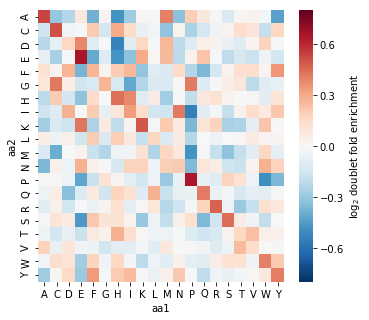

In [14]:
plt.figure(figsize=(5.5, 5))
sns.heatmap(dfmat, vmin=-0.8, vmax=0.8, cmap='RdBu_r', cbar_kws=dict(label='log$_2$ doublet fold enrichment'))

In [15]:
df1, df2 = counter_to_df(counters[0], norm=True), counter_to_df(counters[1], norm=False)
df1.set_index('seq', inplace=True)
df2 = df2[~df2['seq'].str.contains('U')]
df2['aa1'] = [s[0] for s in df2['seq']]
df2['aa2'] = [s[1] for s in df2['seq']]
df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]*df2['count'].sum()) for s in df2['seq']]
pivot = df2.pivot(columns='aa1', index='aa2')

Text(0.5,0,'expected counts')

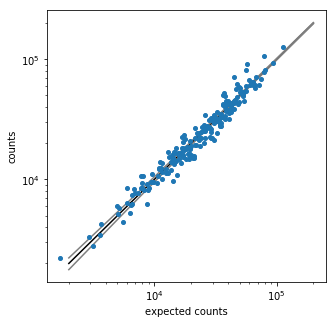

In [23]:
mask = np.tri(*pivot['count'].shape, k=-1)
plt.figure(figsize=(5, 5))
x = np.linspace(2e3, 2e5)
plt.plot(x, x, 'k')
plt.plot(x, x+5*x**.5, 'gray')
plt.plot(x, x-5*x**.5, 'gray')
arr = np.ma.array(pivot['theory'], mask=mask)
arrT = np.ma.array(pivot['count'], mask=mask)
plt.plot(arr.flatten(), arrT.flatten(), 'o', ms=4)
#plt.plot(x, 1.3*x, 'g')
#plt.plot(x, x/1.3, 'g')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('counts')
plt.xlabel('expected counts')

# Mirror sequence analysis

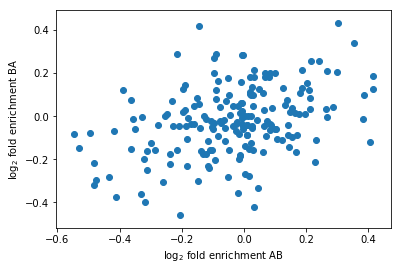

In [25]:
mask = np.tri(*pivot['count'].shape, k=0)
enrichment = np.log2(pivot['count']/pivot['theory'])
plt.scatter(np.ma.array(enrichment, mask=mask),
            np.ma.array(enrichment.T, mask=mask))
plt.xlabel('log$_2$ fold enrichment AB')
plt.ylabel('log$_2$ fold enrichment BA');

In [26]:
df2 = counter_to_df(counters[1], norm=False)
df2 = df2[~df2['seq'].str.contains('U')]
df2['aa1'] = [s[0] for s in df2['seq']]
df2['aa2'] = [s[1] for s in df2['seq']]
counts = df2.pivot(columns='aa1', index='aa2')['count']

Text(0.5,0,'counts of AB')

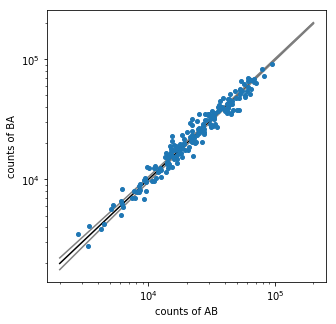

In [27]:
plt.figure(figsize=(5, 5))
x = np.linspace(2e3, 2e5)
plt.plot(x, x, 'k')
plt.plot(x, x+5*x**.5, 'gray')
plt.plot(x, x-5*x**.5, 'gray')
arr = np.ma.array(counts, mask=mask)
arrT = np.ma.array(counts.T, mask=mask)
plt.plot(arr.flatten(), arrT.flatten(), 'o', ms=4)
#plt.plot(x, 1.3*x, 'g')
#plt.plot(x, x/1.3, 'g')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('counts of BA')
plt.xlabel('counts of AB')

Text(28.5,0.5,'amino acid 2')

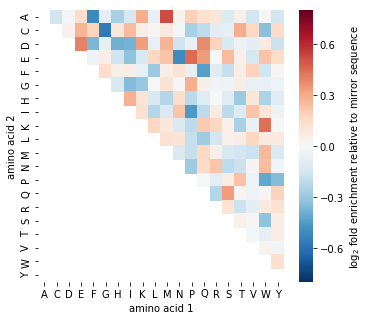

In [28]:
plt.figure(figsize=(5.5, 5))
fold = np.log2(counts/counts.T)
sns.heatmap(fold, mask=mask, vmin=-0.8, vmax=0.8, cmap='RdBu_r',
            cbar_kws=dict(label='log$_2$ fold enrichment relative to mirror sequence'))
plt.xlabel('amino acid 1')
plt.ylabel('amino acid 2')

# amino acid frequencies across different proteins

In [29]:
aas = unique_amino_acids(fasta_iter(human))

In [30]:
def aa_frequencies(proteome, min_length=1):
    n = sum([1 for h, seq in fasta_iter(proteome) if len(seq)>=min_length])
    array = np.zeros((n, len(aas)))
    i = 0
    for h, seq in fasta_iter(proteome):
        seq = seq.replace('X', '')
        if len(seq) < min_length:
            continue
        counter = {}
        for aa in aas:
            counter[aa] = 0
        count_kmers(seq, 1, counter=counter)
        sum_ = np.sum(list(counter.values()))
        for j, aa in enumerate(aas):
            array[i, j] = counter[aa]/sum_
        i += 1
    return array

In [31]:
min_length=200
aa_human = aa_frequencies(human, min_length=min_length)
aa_malaria = aa_frequencies(malaria, min_length=min_length)
aa_influenzaB = aa_frequencies(influenzaB, min_length=min_length)
aa_cmv = aa_frequencies(cmv, min_length=min_length)

(-0.3, 0.3)

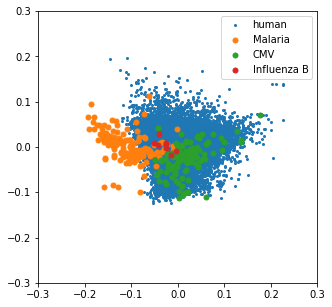

In [33]:
plt.figure(figsize=(5, 5))
pca = sklearn.decomposition.PCA(n_components=2)
pcad_human = pca.fit_transform(aa_human)
plt.scatter(pcad_human[:, 0], pcad_human[:, 1], s=4, label='human')
for label, aa in [('Malaria', aa_malaria), ('CMV', aa_cmv), ('Influenza B', aa_influenzaB), ]:
    pcad_pathogen = pca.transform(aa)
    plt.scatter(pcad_pathogen[:, 0], pcad_pathogen[:, 1], label=label, s=25)
plt.legend()
lim = 0.3
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

(-0.3, 0.3)

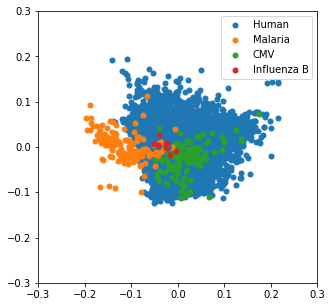

In [34]:
plt.figure(figsize=(5, 5))
pca = sklearn.decomposition.PCA(n_components=2)
pca = pca.fit(np.vstack([aa_human, aa_malaria, aa_cmv, aa_influenzaB]))
for label, aa in [('Human', aa_human), ('Malaria', aa_malaria), ('CMV', aa_cmv), ('Influenza B', aa_influenzaB)]:
    pcad_pathogen = pca.transform(aa)
    plt.scatter(pcad_pathogen[:, 0], pcad_pathogen[:, 1], label=label, s=25)
plt.legend()
lim = 0.3
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

In [44]:
trans = sklearn.manifold.MDS(n_components=2)
aafreqs = [aa_human[:1000, :], aa_malaria, aa_cmv, aa_influenzaB]
transd = trans.fit_transform(np.vstack(aafreqs))

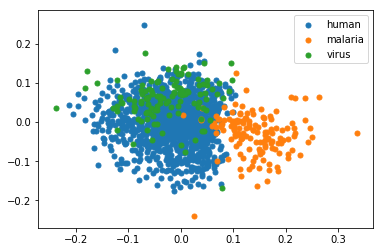

In [45]:
len_aafreqs = [aa.shape[0] for aa in aafreqs]
plt.scatter(transd[:len_aafreqs[0], 0], transd[:len_aafreqs[0], 1], label='human', s=25)
plt.scatter(transd[len_aafreqs[0]:len_aafreqs[0]+aa_malaria.shape[0], 0], transd[len_aafreqs[0]:len_aafreqs[0]+aa_malaria.shape[0], 1], label='malaria', s=25)
plt.scatter(transd[len_aafreqs[0]+aa_malaria.shape[0]:, 0], transd[len_aafreqs[0]+aa_malaria.shape[0]:, 1], label='virus', s=25)
plt.legend()

In [46]:
dfcmv = pd.read_csv('/home/amayer/data/proteomes/cmv-iedb-epitopes.csv', header=1, usecols=(2, 9))
dfcmv['length'] = [len(d) for d in dfcmv['Description']]

In [47]:
def aa_frequencies_list(list_, min_length=1):
    array = np.zeros((len(list_), len(aas)))
    i = 0
    for seq in list_:
        seq = ''.join( c for c in seq if c in list(aas))
        if len(seq) < min_length:
            continue
        counter = {}
        for aa in aas:
            counter[aa] = 0
        count_kmers(seq, 1, counter=counter)
        #sum_ = np.sum(list(counter.values()))
        for j, aa in enumerate(aas):
            array[i, j] = counter[aa]#/sum_
        i += 1
    return array

In [48]:
aa_cmv_epitopes = aa_frequencies_list(list(dfcmv[(dfcmv['length']<25)&(dfcmv['length']>5)]['Description']))
aa_cmv_epitope = aa_cmv_epitopes.sum(axis=0)
aa_cmv_epitope /= np.sum(aa_cmv_epitope)

aah = aa_human.sum(axis=0)
aah /= np.sum(aah)

aac = aa_cmv.sum(axis=0)
aac /= np.sum(aac)

In [ ]:
df = pd.DataFrame(dict(freq=np.concatenate([aah, aac, aa_cmv_epitope]),
                       aas=np.concatenate([aas]*3),
                       provenance=np.concatenate([['human']*len(aas), ['cmv']*len(aas), ['cmv_epitope']*len(aas)])))
df.head()

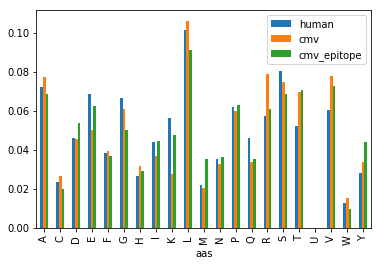

In [51]:
df = pd.DataFrame(dict(human=aah, cmv=aac, cmv_epitope=aa_cmv_epitope, aas=aas))
df.plot.bar(x='aas')

# probability given independent model

In [300]:
df0 = counter_to_df(counters[0])
df0 = df0.set_index('seq')
humanaaprobdict = np.log10(df0['freq']).to_dict()
humanaaprobdict

{'M': -1.6712114813499508,
 'T': -1.2711748107115097,
 'G': -1.1822858153690639,
 'Y': -1.574150296127795,
 'P': -1.199876777577105,
 'D': -1.3242865229636032,
 'E': -1.1484615605550976,
 'K': -1.2421403136826479,
 'L': -1.0017079846543702,
 'R': -1.248516845414329,
 'Q': -1.3214333654093728,
 'W': -1.9141622055432883,
 'S': -1.0796273885260892,
 'V': -1.224272190158989,
 'F': -1.437944600451292,
 'N': -1.4454936422828286,
 'H': -1.5810355227957886,
 'I': -1.3630212858544604,
 'C': -1.6387759392376506,
 'A': -1.1537192183369989,
 'U': -5.487588953020592}

In [252]:
def logprobability(string, charprobdict, k=None):
    if k and (len(string) != k):
        return np.nan
    logp = 0.0
    for c in string:
        try:
            logp += charprobdict[c]
        except:
            logp = np.nan
    return logp

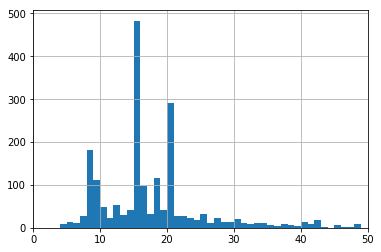

In [276]:
dfepitope = pd.read_csv('/home/amayer/data/proteomes/plasmodiumfalciparum-iedb-epitopes.csv', header=1, usecols=(2, 9))
dfepitope['length'] = [len(d) for d in dfepitope['Description']]
dfepitope['length'].hist(bins=np.arange(50))
plt.xlim(0, 50);

In [289]:
k = 15
epi = list(dfepitope[dfepitope['length']==k]['Description'])
pepitope = np.array([logprobability(s, humanaaprobdict, k) for s in epi])
pepitope = pepitope[~np.isnan(pepitope)]
phuman = np.array([logprobability(seq[i:i+k], humanaaprobdict, k) for i in range(len(seq)-k+1) for h, seq in fasta_iter(human)])
phuman = phuman[~np.isnan(phuman)]
pmalaria = np.array([logprobability(seq[i:i+k], humanaaprobdict, k) for i in range(len(seq)-k+1) for h, seq in fasta_iter(malaria)])
pmalaria = pmalaria[~np.isnan(pmalaria)]

In [294]:
bins = np.linspace(-25, -15, 30)
chuman, bins = np.histogram(phuman, bins=bins)
cepitope, bins = np.histogram(pepitope, bins=bins)
cmalaria, bins = np.histogram(pmalaria, bins=bins)

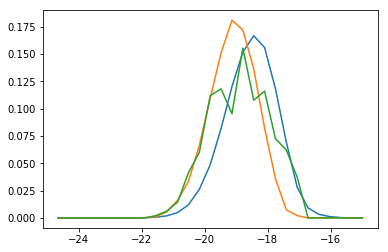

In [297]:
plt.plot(bins[1:], chuman/len(phuman))
plt.plot(bins[1:], cmalaria/len(pmalaria))
plt.plot(bins[1:], cepitope/len(pepitope))
#plt.xscale('log')

In [299]:
np.mean(phuman), np.mean(pmalaria), np.mean(pepitope)

(-18.726047878174736, -19.290275462715808, -19.04663634893747)